# ARIMA

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
from pylab import rcParams
from datetime import datetime
import pmdarima as pm
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import itertools

In [2]:
# Loading in the data
df = pd.read_excel('data/eth_api_data.xlsx')

In [3]:
df['t'] = pd.to_datetime(df['t'])
df.set_index('t', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2226 entries, 2015-08-08 to 2021-09-14
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               2226 non-null   int64  
 1   sending_count       2226 non-null   int64  
 2   receiving_count     2226 non-null   int64  
 3   active_count        2226 non-null   int64  
 4   new_non_zero_count  2226 non-null   int64  
 5   block_height        2226 non-null   int64  
 6   sopr                2226 non-null   float64
 7   price_usd_close     2226 non-null   float64
 8   marketcap_usd       2226 non-null   float64
 9   difficulty_latest   2226 non-null   int64  
 10  hash_rate_mean      2226 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 208.7 KB


In [4]:
price_data = df.filter(['price_usd_close'])

In [5]:
ts = price_data.values

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts)

In [7]:
train_set_len = int(np.ceil(len(ts) * .9))
train_set = scaled_data[0:int(train_set_len), :]
test_set = scaled_data[train_set_len:, :]

In [8]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(price_data)

(0.99, True)

In [9]:
price_data['price_usd_close'].diff().dropna()

t
2015-08-09     -0.050151
2015-08-10     -0.019125
2015-08-11      0.387656
2015-08-12      0.125710
2015-08-13      0.629215
                 ...    
2021-09-10   -216.041406
2021-09-11     54.174026
2021-09-12    144.144946
2021-09-13   -120.741277
2021-09-14    131.123355
Name: price_usd_close, Length: 2225, dtype: float64

In [10]:
adf_test.should_diff(price_data['price_usd_close'].diff().dropna())

(0.01, False)

In [11]:
price_data['c1diff'] = price_data['price_usd_close'] - price_data['price_usd_close'].shift(1)
price_data['c2diff']= price_data['price_usd_close'] - price_data['price_usd_close'].shift(12)
price_data.head()

,price_usd_close,c1diff,c2diff
t,,,
2015-08-08,0.769981,NaN,NaN
2015-08-09,0.719830,-0.050151,NaN
2015-08-10,0.700705,-0.019125,NaN
2015-08-11,1.088361,0.387656,NaN
2015-08-12,1.214071,0.125710,NaN


In [12]:
adf_test.should_diff(price_data['c1diff'].dropna())

(0.01, False)

No handles with labels found to put in legend.


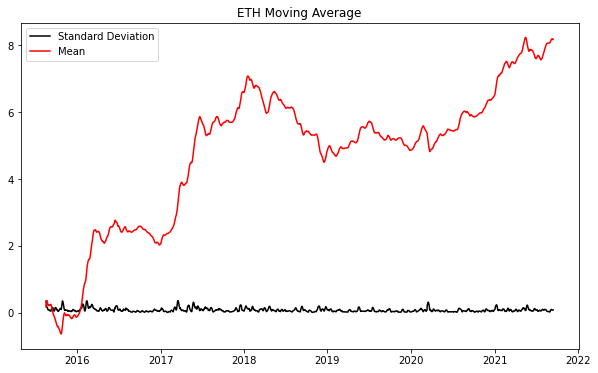

In [13]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(price_data['price_usd_close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('ETH Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show();

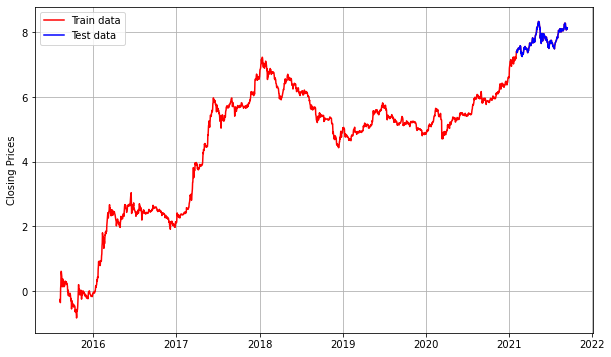

In [14]:
train_set, test_set = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(df_log, 'red', label='Train data')
plt.plot(test_set, 'blue', label='Test data')
plt.legend();

### First ARIMA Model

In [15]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train_set):
    print(train_ind, val_ind)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

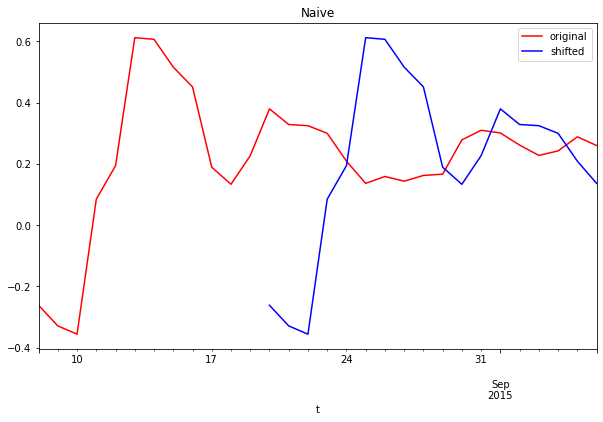

In [16]:
naive = train_set.shift(12)
fig, ax = plt.subplots()

train_set[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Naive')
ax.legend();

In [17]:
np.sqrt(mean_squared_error(train_set[12:], naive.dropna()))

0.2348330536411367

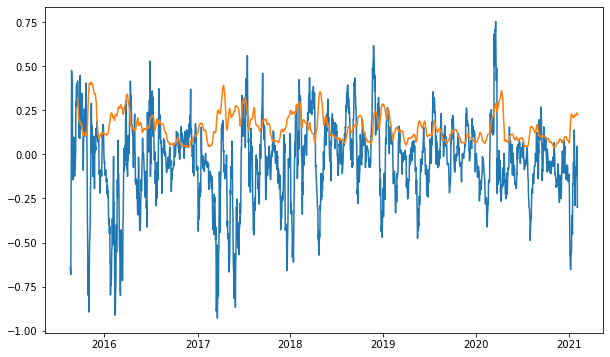

In [18]:
fig, ax = plt.subplots()
residuals = naive[1:] - train_set[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

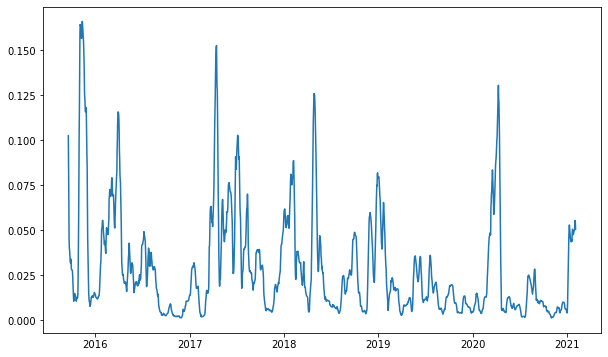

In [19]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var());

### Second ARIMA Model

In [20]:
auto_model = pm.auto_arima(train_set, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12009.223, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5380.437, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.61 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5382.728, Time=0.67 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6752.029, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-5382.899, Time=0.98 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4729.918, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-5380.912, Time=1.11 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=3094.388, Time=0.60 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5378.710, Time=

In [21]:
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 0, 3)
(0, 0, 0, 0)


In [22]:
# The best ARIMA model had p,d,q values of 1, 0, 3
model = ARIMA(train_set, order=(1,0,3))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:        price_usd_close   No. Observations:                 2003
Model:                     ARMA(1, 3)   Log Likelihood                2696.860
Method:                       css-mle   S.D. of innovations              0.063
Date:                Wed, 15 Sep 2021   AIC                          -5381.720
Time:                        09:23:14   BIC                          -5348.105
Sample:                             0   HQIC                         -5369.378
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.7226      3.154      1.180      0.238      -2.460       9.905
ar.L1.price_usd_close     0.9998      0.000   3832.463      0.000       0.999       1.000
ma.L1.pr

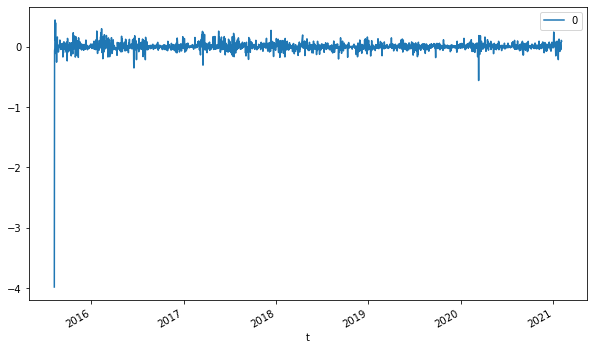

In [23]:
# Plotting the residuals
residuals = pd.DataFrame(fitted.resid)
residuals.plot();

In [24]:
print(residuals.describe())

                 0
count  2003.000000
mean      0.001667
std       0.108960
min      -3.983988
25%      -0.024038
50%       0.000509
75%       0.029374
max       0.443031


In [25]:
fc, se, conf = fitted.forecast(223, alpha=0.05)

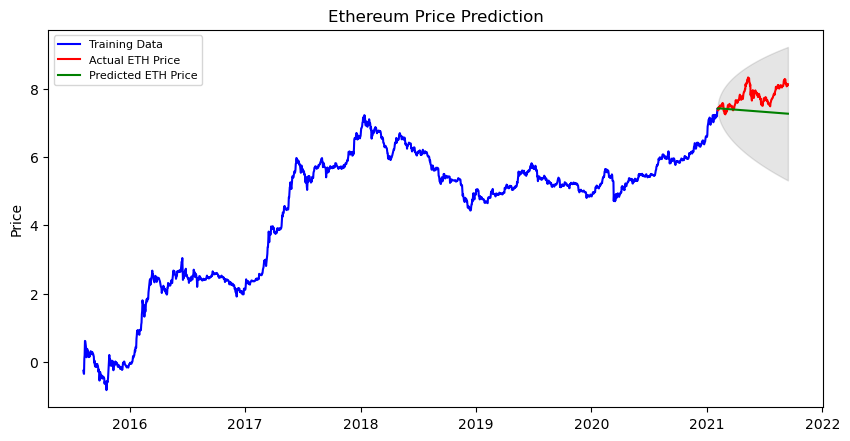

In [26]:
# Making pandas series from the above metrics
fc_series = pd.Series(fc, index=test_set.index)
lower_series = pd.Series(conf[:, 0], index=test_set.index)
upper_series = pd.Series(conf[:, 1], index=test_set.index)

# Plotting the results
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_set, color='blue', label='Training Data')
plt.plot(test_set, color = 'red', label='Actual ETH Price')
plt.plot(fc_series, color = 'green',label='Predicted ETH Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Ethereum Price Prediction')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8);

In [27]:
# Seeing how the model performed
mse = mean_squared_error(test_set, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_set, fc)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(test_set, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_set)/np.abs(test_set))
print('MAPE: '+str(mape))

MSE: 0.2604683440187911
MAE: 0.425007015298497
RMSE: 0.5103609938257342
MAPE: 0.0535735618242534


In [28]:
fc_inv= np.expm1(fc)
test_inv= np.expm1(test_set)

In [29]:
rmse_inv = sqrt(mean_squared_error(test_inv, fc_inv))
print('RMSE: '+str(rmse))

RMSE: 0.5103609938257342
